If you want, you can change the call below to 
```python
%pylab widget
```
and the plots in the notebook will become dynamic (draggable, zoomable, etc) instead of rasterized.  I did not do this by default beacuse the plots don't show up in the GitHub repo if you do.

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
from kde_contour import kdeplot_2d_clevels
import ligo.skymap.kde
import pandas as pd
from scipy.integrate import cumtrapz
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_book
import warnings

sns.set_context('notebook')
sns.set_palette('husl', n_colors=6)
sns.set_style('ticks')

Posterior sample file dowloaded from https://dcc.ligo.org/LIGO-P2000158/public.  There are multiple approximants in the file, but the "preferred" results come from a "NR surrogate" `NRSur7dq4`.  Execute the `curl` command below to re-download the posterior sample file and compare its MD5.  I, Farr, find 
```shell
% openssl md5 GW190521_posterior_samples.h5
MD5(GW190521_posterior_samples.h5)= 8af9bce0b55b5ebed7853dbfaa69a2d5
```

In [ ]:
!curl -O https://dcc.ligo.org/public/0168/P2000158/004/GW190521_posterior_samples.h5
!openssl md5 GW190521_posterior_samples.h5

In [3]:
with h5py.File('GW190521_posterior_samples.h5', 'r') as f:
    print(list(f.keys()))
    samples = array(f['NRSur7dq4/posterior_samples'])

['IMRPhenomPv3HM', 'NRSur7dq4', 'SEOBNRv4PHM', 'history', 'version']


In [4]:
rng = np.random.default_rng(227735503557159763068367766824777508503)
c = rng.choice(len(samples), replace=False, size=16384)
sky_samples = pd.DataFrame({
    'x': samples['luminosity_distance'][c]*cos(samples['ra'][c])*cos(samples['dec'][c]),
    'y': samples['luminosity_distance'][c]*sin(samples['ra'][c])*cos(samples['dec'][c]),
    'z': samples['luminosity_distance'][c]*sin(samples['dec'][c])
})
sky_samples_plot = pd.DataFrame({
    r'$x$ ($\mathrm{Mpc}$)': samples['luminosity_distance'][c]*cos(samples['ra'][c])*cos(samples['dec'][c]),
    r'$y$ ($\mathrm{Mpc}$)': samples['luminosity_distance'][c]*sin(samples['ra'][c])*cos(samples['dec'][c]),
    r'$z$ ($\mathrm{Mpc}$)': samples['luminosity_distance'][c]*sin(samples['dec'][c])
})

[Graham, et al. (2020)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.251102) reports the AGN at $\mathrm{RA} = 192.42625^\circ$, $\mathrm{DEC} = 34.82472^\circ$, and $z = 0.438$.  Converting to $xyz$ we have 

In [5]:
ra = 192.42625*pi/180.0
dec = 34.82472*pi/180
zcounter = 0.438
dcounter = Planck15.luminosity_distance(zcounter).to(u.Mpc).value
xcounter = dcounter*cos(ra)*cos(dec)
ycounter = dcounter*sin(ra)*cos(dec)
zcounter = dcounter*sin(dec)

pt_counter = array([xcounter, ycounter, zcounter])

This is a pretty typical skymap: there are two blobs on the sky.  It would be better to do some clustering or use the routines in https://lscsoft.docs.ligo.org/ligo.skymap/#plotting-and-visualization-ligo-skymap-plot, but we're being quick and dirty here.  The KDE that is estimated from the 3D positions will be over-dispersed because its bandwidth will be trying to account for the two blobs on either side of the origin; so take these results with a grain of salt.

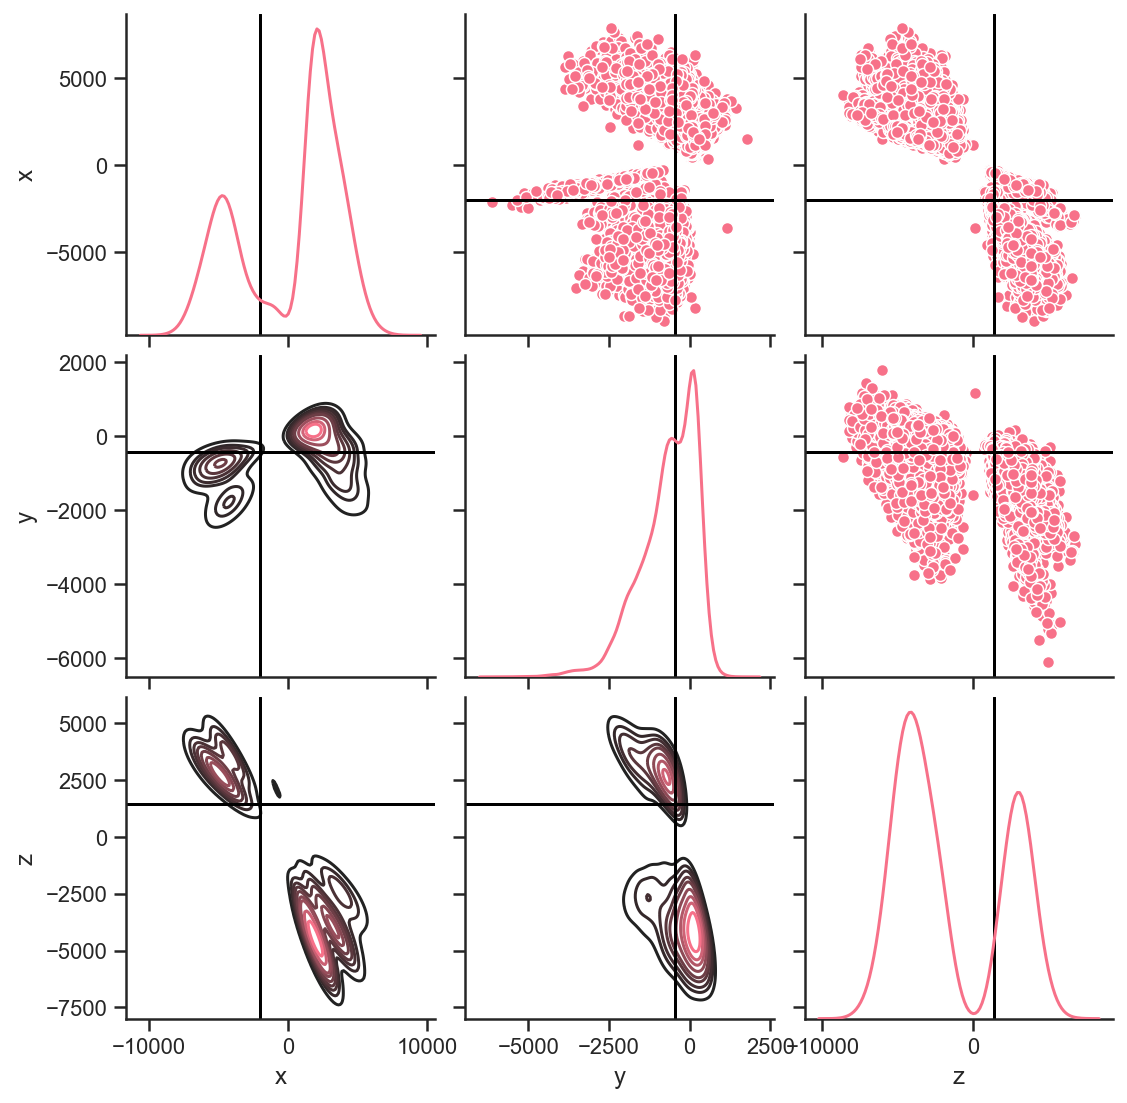

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Don't bitch about unused 'label' keyword.
    g = sns.PairGrid(sky_samples, diag_sharey=False)
    g.map_diag(sns.kdeplot)
    g.map_lower(kdeplot_2d_clevels)
    g.map_upper(sns.scatterplot)

    for i in range(3):
        for j in range(3):
            if i == j:
                g.axes[i,j].axvline(pt_counter[i], color='k')
            else:
                g.axes[i,j].axhline(pt_counter[i], color='k')
                g.axes[i,j].axvline(pt_counter[j], color='k')

Or, let's look at it in 3D:

Text(0.5, 0, '$z$ ($\\mathrm{Mpc}$)')

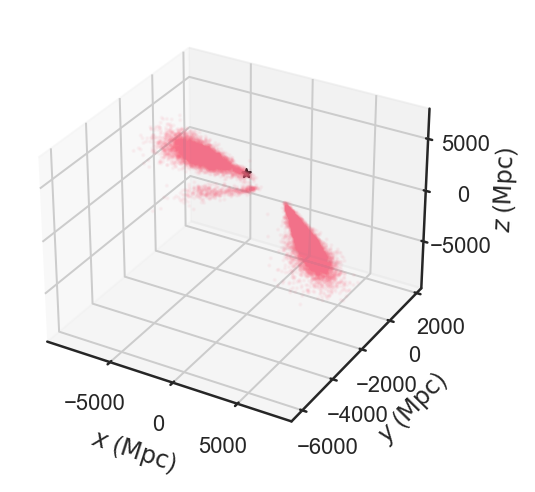

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sky_samples['x'], sky_samples['y'], sky_samples['z'], marker='.', s=5, alpha=0.05)
ax.scatter(xcounter, ycounter, zcounter, marker='*', color='k', s=20)
ax.set_xlabel(r'$x$ ($\mathrm{Mpc}$)')
ax.set_ylabel(r'$y$ ($\mathrm{Mpc}$)')
ax.set_zlabel(r'$z$ ($\mathrm{Mpc}$)')

To get a quick sense of the fraction of the volume posterior that would have to be searched before landing on the AGN, we rank the posterior samples according to an estimate of their 3D posterior density, and determine what fraction lie at lower rank than the AGN location.

In [8]:
pts = row_stack((sky_samples['x'], sky_samples['y'], sky_samples['z']))
kde = ss.gaussian_kde(pts)
p_pts = kde(pts)
p_counterpart = kde(pt_counter)

print('AGN lies at the {:.2f} percentile of the posterior'.format(count_nonzero(p_pts > p_counterpart) / float(len(p_pts))))

AGN lies at the 0.82 percentile of the posterior


We can also look at the marginal distance posterior along the LOS to the AGN.  Again, remember that the KDE is over-dispersed; a proper analysis would be more careful about clustering before computing KDEs.  Given that, however, we can just evaluate the full posterior along the line toward the AGN and re-normalize to obtain the conditional posterior for distance at the AGN location.

Note that this is the conditional posterior density in 3D luminosity-volume---and since our prior is flat in this space, this is proportional to the GW likelihood for distance.

In [9]:
r_counter = sqrt(dot(pt_counter, pt_counter))
ds = linspace(0, 4*r_counter, 1024)
xhat = pt_counter / sqrt(dot(pt_counter, pt_counter))
pdist = kde(row_stack(ds[newaxis,:]*xhat[:,newaxis]))
pdist /= trapz(pdist, ds)

Text(0, 0.5, '$p\\left( d_\\mathrm{GW} \\mid d_L, \\mathrm{RA}=\\alpha, \\mathrm{DEC}=\\delta \\right)$')

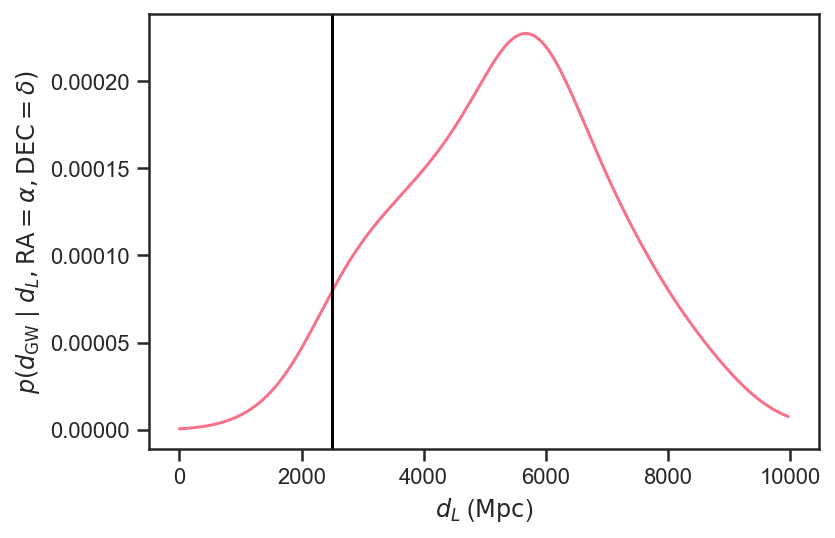

In [10]:
figure()
plot(ds, pdist)
axvline(r_counter, color='k')
xlabel(r'$d_L$ ($\mathrm{Mpc}$)')
ylabel(r'$p\left( d_\mathrm{GW} \mid d_L, \mathrm{RA}=\alpha, \mathrm{DEC}=\delta \right)$')

Sometimes these things work better in the principal axes of the skymap.  Here's what that looks like.  We rotate the point cloud so that the covariance matrix is diagonal.

In [11]:
pts = column_stack((sky_samples['x'], sky_samples['y'], sky_samples['z']))
S = cov(pts, rowvar=False)
evals, evecs = np.linalg.eigh(S)
rot_pts = np.dot(evecs.T, pts.T).T
rot_counter = np.dot(evecs.T, pt_counter)

In [12]:
rot_sky = pd.DataFrame({
    r'$\tilde{x}$ ($\mathrm{Mpc}$)': rot_pts[:,0],
    r'$\tilde{y}$ ($\mathrm{Mpc}$)': rot_pts[:,1],
    r'$\tilde{z}$ ($\mathrm{Mpc}$)': rot_pts[:,2]
})

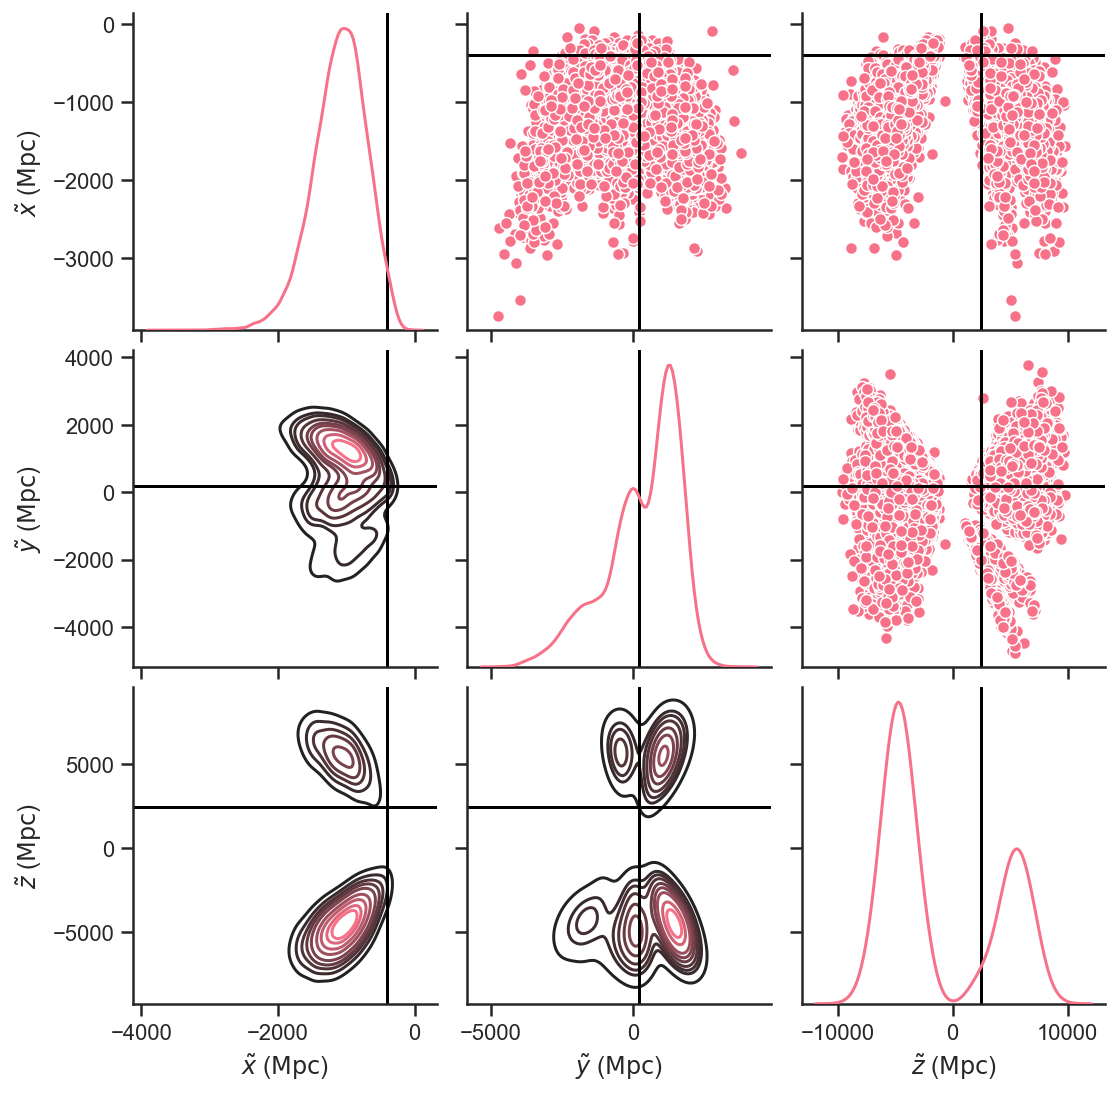

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Don't bitch about unused 'label' keyword.
    g = sns.PairGrid(rot_sky, diag_sharey=False)
    g.map_diag(sns.kdeplot)
    g.map_lower(kdeplot_2d_clevels)
    g.map_upper(sns.scatterplot)

    for i in range(3):
        for j in range(3):
            if i == j:
                g.axes[i,j].axvline(rot_counter[i], color='k')
            else:
                g.axes[i,j].axhline(rot_counter[i], color='k')
                g.axes[i,j].axvline(rot_counter[j], color='k')

It looks like the clusters separate well across the origin in $\tilde{z}$ so let's just implement that by hand.

In [14]:
pos_sel = rot_pts[:,2]>0
neg_sel = rot_pts[:,2]<0
N_pos = count_nonzero(pos_sel)
N_neg = count_nonzero(neg_sel)
kde_pos = ss.gaussian_kde(rot_pts[pos_sel,:].T)
kde_neg = ss.gaussian_kde(rot_pts[neg_sel,:].T)

def cdens(pts):
    return (N_pos*kde_pos(pts) + N_neg*kde_neg(pts))/(N_pos+N_neg)

In [15]:
p_pts = cdens(rot_pts.T)
p_counter = cdens(rot_counter)

In [16]:
print('Counterpart found at the {:.2f} credible level of the posterior'.format(count_nonzero(p_pts > p_counter) / float(len(p_pts))))

Counterpart found at the 0.70 credible level of the posterior


Now we plot the contour levels, but with the split KDE; you can see why there is a better credible level for the counterpart because the split KDE brings out the "bump" in the $z > 0$ cluster:

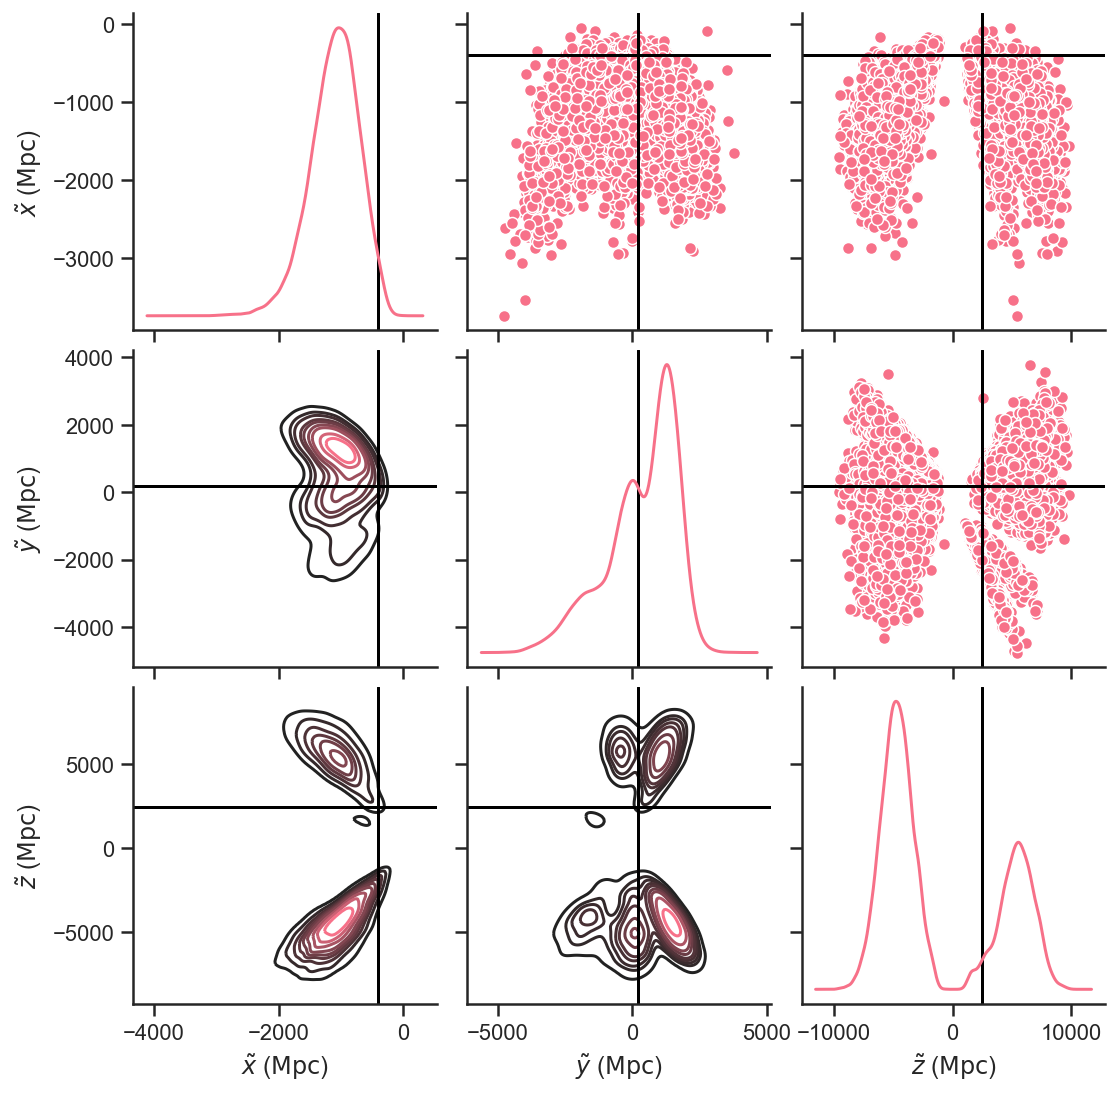

In [17]:
def kdeplot_2d_clevels_split(xs, ys, levels=11, **kwargs):
    try:
        len(levels)
        f = 1 - np.array(levels)
    except TypeError:
        f = linspace(0, 1, levels)[1:-1]
    k_pos = ss.gaussian_kde(row_stack((xs[pos_sel], ys[pos_sel])))
    k_neg = ss.gaussian_kde(row_stack((xs[neg_sel], ys[neg_sel])))
    k = lambda pts: (N_pos*k_pos(pts) + N_neg*k_neg(pts))/(N_pos+N_neg)
    size = max(10*(len(f)+2), 500)
    c = np.random.choice(len(xs), size=size)
    p = k(row_stack((xs[c], ys[c])))
    i = argsort(p)
    l = array([p[i[int(round(ff*len(i)))]] for ff in f])

    Dx = np.percentile(xs, 99) - np.percentile(xs, 1)
    Dy = np.percentile(ys, 99) - np.percentile(ys, 1)

    x = linspace(np.percentile(xs, 1)-0.1*Dx, np.percentile(xs, 99)+0.1*Dx, 128)
    y = linspace(np.percentile(ys, 1)-0.1*Dy, np.percentile(ys, 99)+0.1*Dy, 128)

    XS, YS = meshgrid(x, y, indexing='ij')
    ZS = k(row_stack((XS.flatten(), YS.flatten()))).reshape(XS.shape)

    if 'cmap' not in kwargs:
        line, = plot([], [])
        kwargs['cmap'] = sns.dark_palette(line.get_color(), as_cmap=True)

    ax = kwargs.pop('ax', gca())

    ax.contour(XS, YS, ZS, levels=l, **kwargs)

def kdeplot_split(xs, *args, **kwargs):
    xmin = np.min(xs)
    xmax = np.max(xs)
    Dx = xmax - xmin
    
    xplot = linspace(xmin-0.1*Dx, xmax+0.1*Dx, 1024)
    k_pos = ss.gaussian_kde(xs[pos_sel])
    k_neg = ss.gaussian_kde(xs[neg_sel])
    
    plot(xplot, (N_pos*k_pos(xplot) + N_neg*k_neg(xplot))/(N_pos+N_neg), *args, **kwargs)
    

with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Don't bitch about unused 'label' keyword.
    g = sns.PairGrid(rot_sky, diag_sharey=False)
    g.map_diag(kdeplot_split)
    g.map_lower(kdeplot_2d_clevels_split)
    g.map_upper(sns.scatterplot)

    for i in range(3):
        for j in range(3):
            if i == j:
                g.axes[i,j].axvline(rot_counter[i], color='k')
            else:
                g.axes[i,j].axhline(rot_counter[i], color='k')
                g.axes[i,j].axvline(rot_counter[j], color='k')

How about a 3D version that uses the estimated log-posterior to color the points:

Text(0.5, 0, '$z$ ($\\mathrm{Mpc}$)')

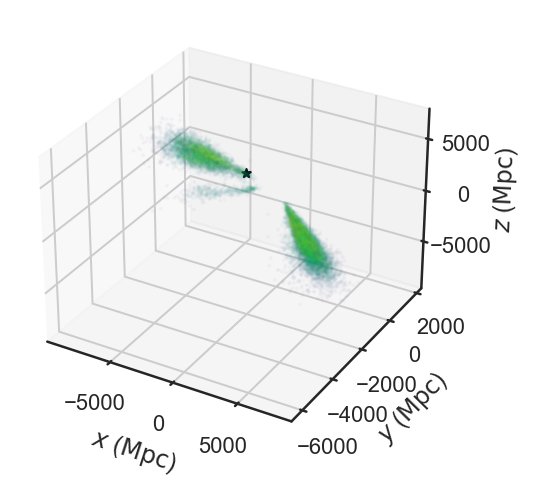

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sky_samples['x'], sky_samples['y'], sky_samples['z'], marker='.', s=5, alpha=0.02, cmap='viridis', c=p_pts, norm=mpl.colors.LogNorm())
ax.scatter(xcounter, ycounter, zcounter, marker='*', color='k', s=20)
ax.set_xlabel(r'$x$ ($\mathrm{Mpc}$)')
ax.set_ylabel(r'$y$ ($\mathrm{Mpc}$)')
ax.set_zlabel(r'$z$ ($\mathrm{Mpc}$)')

And we can make the same conditional distance posterior plot as above using the new clustered KDE:

In [19]:
rot_d = np.sqrt(np.dot(rot_counter, rot_counter)) # Better be the same as D---that's what rotations do....
print('double check: d = {:.3f} Mpc, rot_d = {:.3f} Mpc'.format(dcounter, rot_d)) # Whew
rot_counter_hat = rot_counter / rot_d

ds = linspace(0, 5*rot_d, 1024)
ps = rot_counter_hat[newaxis,:]*ds[:,newaxis]
pps = cdens(ps.T)
pps /= trapz(pps, ds) # Normalize

double check: d = 2492.434 Mpc, rot_d = 2492.434 Mpc


If we evaluate the clustered 

Text(0, 0.5, '$p\\left( d_\\mathrm{GW} \\mid d_L, \\mathrm{RA}=\\alpha, \\mathrm{DEC}=\\delta \\right)$')

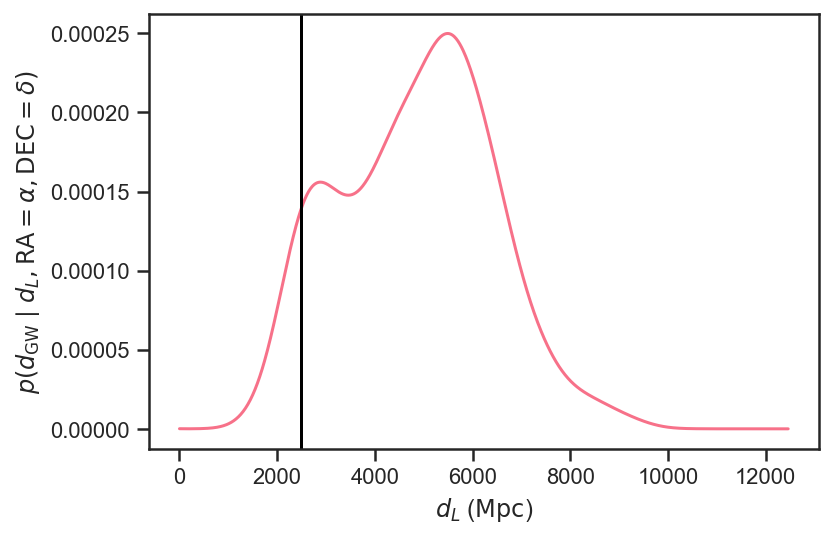

In [20]:
figure()
plot(ds, pps)
axvline(rot_d, color='k')
xlabel(r'$d_L$ ($\mathrm{Mpc}$)')
ylabel(r'$p\left( d_\mathrm{GW} \mid d_L, \mathrm{RA}=\alpha, \mathrm{DEC}=\delta \right)$')

Just to avoid the clustering / KDEing issue entirely, here we just cut the posterior samples down to those w/i a 3-degree cone around the AGN location.  (I chose 3 degrees via the very scientific procedure of that being the first integer cone angular size that had more than 1k points in it.)

<ipython-input-21-f716185a0204>:5: RuntimeWarning: divide by zero encountered in true_divide
  ps = (k(ds) + k(-ds))/(ds*ds) # Reflect about d = 0 boundary


Text(0, 0.5, '$p\\left( d_\\mathrm{GW} \\mid d_L, \\mathrm{RA}=\\alpha, \\mathrm{DEC}=\\delta \\right)$')

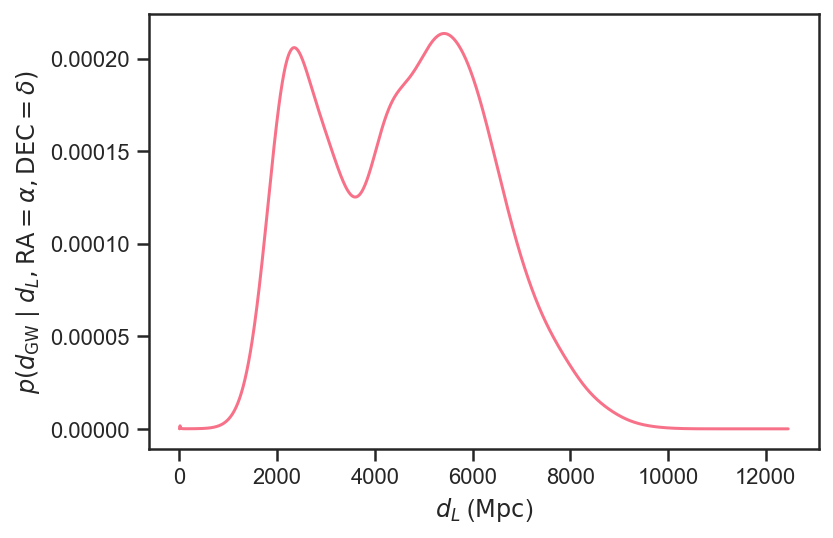

In [21]:
figure()
r = 3 # deg
sel = np.sqrt(np.square((ra - samples['ra'])*cos(dec)) + np.square((dec - samples['dec']))) < r*pi/180.0
k = ss.gaussian_kde(samples['luminosity_distance'][sel])
ps = (k(ds) + k(-ds))/(ds*ds) # Reflect about d = 0 boundary
ps[0] = 0.0 # Singularity at d = 0
pps = ps / trapz(ps, ds)
plot(ds, pps)
xlabel(r'$d_L$ ($\mathrm{Mpc}$)')
ylabel(r'$p\left( d_\mathrm{GW} \mid d_L, \mathrm{RA}=\alpha, \mathrm{DEC}=\delta \right)$')

Let's see where the counterpart falls in the conditional distance posterior:

In [28]:
ds_cond = samples['luminosity_distance'][sel]
print('With default d_L^2 prior, counterpart found at {:.2f} CL'.format(count_nonzero(ds_cond < dcounter)/float(len(ds_cond))))

With default d_L^2 prior, counterpart found at 0.03 CL


But a more reasonable prior would be uniform in comoving volume, not uniform in $d_L^3$.  Re-weighting:

In [29]:
zs_cond = array([cosmo.z_at_value(Planck15.luminosity_distance, d*u.Mpc) for d in tqdm(ds_cond)])
z_wt = (4*pi*Planck15.differential_comoving_volume(zs_cond)/(1+zs_cond)/Planck15.luminosity_distance(zs_cond)**2).value
zcounter = cosmo.z_at_value(Planck15.luminosity_distance, dcounter*u.Mpc)

print('With uniform in comoving frame prior, counterpart found at {:.2f} CL'.format(np.sum(z_wt[zs_cond < zcounter])/np.sum(z_wt)))

100%|██████████| 1356/1356 [00:07<00:00, 183.37it/s]


With uniform in comoving frame prior, counterpart found at 0.08 CL


One more final option wrt clustering.  We *could* use the `ligo.skymap.kde.Clustered3DSkyKDE` code, but it's slow, and chooses the clustering according to a recipe (optimizing the BIC) that is not necessarily optimal.  And it would be instructive anyway to roll our own code.  Below we do something similar to `ligo.skymap.kde.Clustered3DSkyKDE`.  We split the set of points into a training set (90%) and a test set (10%), and then try different numbers of clusters (up to 20) via k-means.  Within each cluster, we use a KDE to estimate the density, and combine the KDEs with weights proportional to the number of points in each cluster.  The optimal number of clusters is chosen by optimizing the likelihood of the test set after clustering on the training set.

In [22]:
class ClusteredKDE(object):
    def __init__(self, pts, assign):
        self.ncluster = np.max(assign)+1
        self.wts = []
        self.kdes = []
        
        for i in range(self.ncluster):
            p = pts[assign==i,:]
            self.wts.append(p.shape[0] / float(pts.shape[0]))
            self.kdes.append(ss.gaussian_kde(p.T))
            
    def __call__(self, p):
        return np.sum(np.array([wt*k(p.T) for wt, k in zip(self.wts, self.kdes)]), axis=0)

In [25]:
pts = sky_samples[['x', 'y', 'z']].to_numpy()
ntest = pts.shape[0]//10
test_pts = pts[:ntest,:]
train_pts = pts[ntest:,:]

best_kde = None
best_assign = None
best_logl = np.NINF

logls = []

# Range of cluster number chosen by hand
for ncl in tqdm(range(10, 30)):
    # Since k-means is random, try five times for different clustering.
    for _ in range(5):
        _, assign = ligo.skymap.kde.k_means(train_pts, ncl)
        k = ClusteredKDE(train_pts, assign)
        ll = np.sum(np.log(k(test_pts)))
        logls.append(ll)
        if ll > best_logl:
            best_logl = ll
            best_kde = k
            best_assign = assign

100%|██████████| 20/20 [03:12<00:00,  9.64s/it]


Best likelihood achieved with 24 clusters


Text(0, 0.5, '$\\log \\mathcal{L}_\\mathrm{test}$')

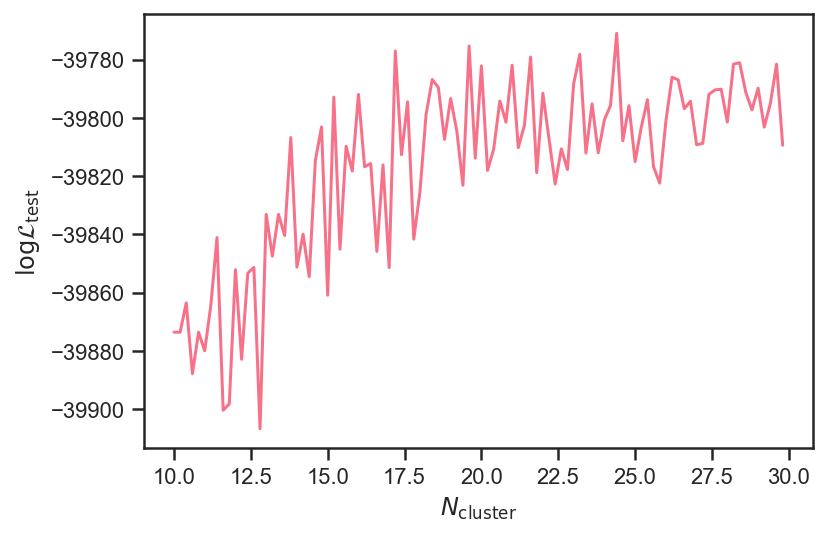

In [29]:
print('Best likelihood achieved with {:d} clusters'.format(best_kde.ncluster))
plot(arange(len(logls))/5.0+10, logls)
xlabel(r'$N_\mathrm{cluster}$')
ylabel(r'$\log \mathcal{L}_\mathrm{test}$')

We can make a 3D plot of the various point clusters (it's colorful anyway):

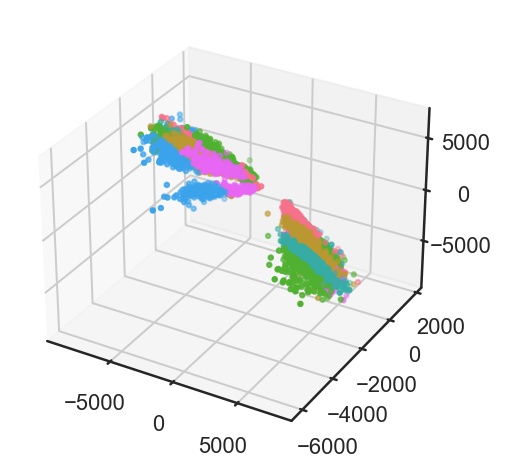

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
with sns.color_palette('husl', n_colors=best_kde.ncluster):
    for i in range(best_kde.ncluster):
        pts = sky_samples.iloc[ntest:].loc[best_assign==i]
        ax.scatter(pts['x'], pts['y'], pts['z'], marker='.')

Here we calculate the conditional distance posterior determined by the clustered KDE:

In [59]:
ds = linspace(0, 1.1*np.max(samples['luminosity_distance']), 1024)
r = array([xcounter, ycounter, zcounter])
rhat = r / np.sqrt(np.dot(r,r))
ps = best_kde(ds[:,newaxis]*rhat[newaxis,:])
pps = ps / trapz(ps, ds)

From this plot, it is clear that the clustered KDE over-fits the likelihood function, but that first peak is rather smooth.

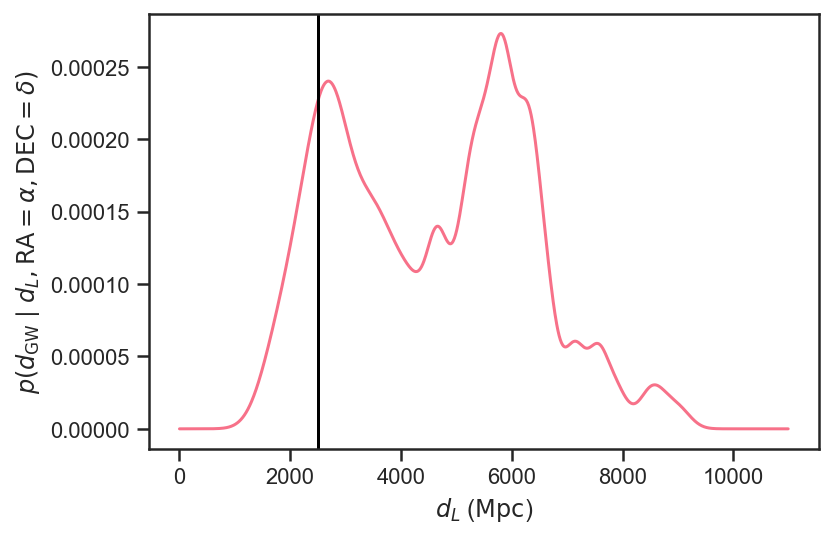

In [70]:
plot(ds, pps)
xlabel(r'$d_L$ ($\mathrm{Mpc}$)')
ylabel(r'$p\left( d_\mathrm{GW} \mid d_L, \mathrm{RA}=\alpha, \mathrm{DEC}=\delta \right)$')
axvline(dcounter, color='k')

A fun exercise is to use the measured redshift of the AGN ($z = 0.438$) to turn our distance measurement into a measurement of $H_0$ (assuming other cosmological parameters are fixed).  Let's compute a marginal likelihood for $H_0$, at least for $35 \, \mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1} \leq H_0 \leq 140 \, \mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$.  That means we need to work out what the implied prior is on $H_0$ given the LVC's $d_L^2$ prior on distance (applies to both the conditional and un-conditional distances).  A nice trick for measuring $H_0$ in this very simplified model is to note that it is inversely proportional to luminosity distance, so 
$$
H_0\left( d_L \mid z_\mathrm{AGN} \right) = \frac{d_{L,\mathrm{AGN}}\left( z_\mathrm{AGN} \mid H_{0,\mathrm{Planck}} \right)}{d_L} H_{0, \mathrm{Planck}},
$$
which works as long as we hold the remainder of cosmology fixed (since $H_0$ is then just a scale factor on the inverse luminosity distance).  

What we have plotted above is evaluating the 3D KDE for the location in luminosity distance space along the ray toward the counterpart; since the LIGO/Virgo/Kagra prior is uniform in this 3D space, this is proportional to the likelihood function evaluated along the ray.  Thus, we do not need any Jacobian transformation to remove the prior; we just need to evaluate our likelihood in terms of $H_0$, which we do below. 

This has been a point of confusion, and the next-to-last, incorrect reasoning that appeared previously in this notebook is below:

**Here is an incorrect piece of reasoning**

We want to convert our posterior on $d_L$ into a likelihood, so we need to divide by the prior (LIGO uses $d_L^2 \propto H_0^{-2}$).  Once we have a likelihood function, there is no further change needed to write it in terms of $H_0$ instead of $d_L$ (note: I messed this up the first time I made this plot; I multiplied by $H_0^4$ as if converting posteriors, but forgot that there needs to be an additional factor of $\partial d / \partial H_0 \propto H_0^{-2}$, leaving a net $H_0^{-2}$ as we discuss here).

In [61]:
H0_of_d = rot_d / ds * Planck15.H0.to(u.km/u.s/u.Mpc).value
sel = (35 < H0_of_d) & (H0_of_d < 140)
H0_of_d = H0_of_d[sel][::-1]
p_H0 = pps.copy()[sel][::-1]
p_H0 /= trapz(p_H0, H0_of_d)

<ipython-input-61-390196a84025>:1: RuntimeWarning: divide by zero encountered in true_divide
  H0_of_d = rot_d / ds * Planck15.H0.to(u.km/u.s/u.Mpc).value


Planck15 H0 found at p = 0.50 in likelihood


Text(0.5, 1.0, '$H_0 = 68^{+26}_{-19} \\, \\mathrm{km} \\, \\mathrm{s}^{-1} \\, \\mathrm{Mpc}^{-1}$')

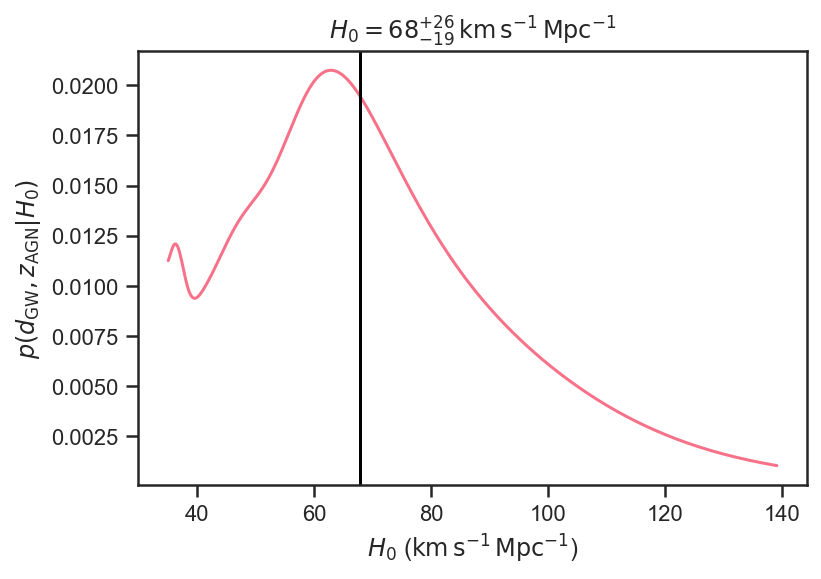

In [62]:
figure()
plot(H0_of_d, p_H0)
axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value, color='k')
xlabel(r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
ylabel(r'$p\left( d_\mathrm{GW}, z_\mathrm{AGN} | H_0 \right)$')

c_H0 = cumtrapz(p_H0, H0_of_d, initial=0)
print('Planck15 H0 found at p = {:.2f} in likelihood'.format(interp(Planck15.H0.to(u.km/u.s/u.Mpc).value, H0_of_d, c_H0)))
m = interp(0.5, c_H0, H0_of_d)
l = interp(0.16, c_H0, H0_of_d)
h = interp(0.84, c_H0, H0_of_d)
title(r'$H_0 = {:.0f}^{{+{:.0f}}}_{{-{:.0f}}} \, \mathrm{{km}} \, \mathrm{{s}}^{{-1}} \, \mathrm{{Mpc}}^{{-1}}$'.format(m, h-m, m-l))

The Bayes factor (i.e. likelihood of association) is given by the posterior density at the proposed counterpart divided by the prior density.  The LIGO prior is uniform in (luminosity distance)^3, so in our rotated xyz coordinate system it is uniform, and given by $1/V$ where $V$ is the volume of the prior region.  If we take this to be a sphere that encloses all our posterior samples, but only just, then we obtain the "minimal" Bayes factor for the association, computed below.  

In [64]:
prior_density = 1/(4/3*pi*np.max(samples['luminosity_distance'])**3)
bf = best_kde(array([xcounter, ycounter, zcounter])) / prior_density
print('Bayes factor for the association is {:.1f}'.format(bf[0]))

Bayes factor for the association is 90.9


Now we need to consider selection effects.  This is going to be a complete hack, but given the accuracy of our measurement is hopefully OK.  We need to introduce a weighting factor, $\beta\left( H_0 \right)$ (see, e.g., [Abbott, et al. (2017)](https://arxiv.org/pdf/1710.05835.pdf), [Fishbach, et al. (2018)](https://arxiv.org/pdf/1807.05667.pdf), [Farr & Gair (2018)](https://github.com/farr/H0StatisticalLikelihood)), that accounts for the fraction of the population of GW+EM events that is observable.  We make the following simplifying assumptions:

* Any AGN merger flaring event that is detectable in GW is either also detectable as a EM flare, or would be missing an EM detection *at random* (e.g. if the EM followup us only able to observe some subset of the sky that is independent of the event properties).  This lets us only consider the GW selection function.
* We approximate the GW selection function as a fixed luminosity distance cut.  In reality the observable volume for any class of system has a non-uniform shape on the sky, and further varies as a function of the intrinsic properties of the event; so this is a *very rough* approximation.

But under these approximations it is straghtforward to compute the `beta` factor (that is, the fraction of the population that is detectable).  Below we evaluate this factor under two reasonable assumptions: 

1. That the merger rate is constant in the comoving frame to $z = 10$.
1. That the merger rate traces the [Madau & Dickinson (2014)](https://arxiv.org/abs/1403.0007) star formation rate in the comoving frame with $1 < z < 10$:
  $$
  \frac{\mathrm{d} N}{\mathrm{d} V \mathrm{d} t} \propto \frac{\left( 1 + z \right)^{2.7}}{1 + \left( \frac{1 + z}{1 + 1.9} \right)^{5.6}}
  $$

In [65]:
zs = expm1(linspace(log(1), log(1+10), 1024))
H0s = logspace(log10(35), log10(140), 128)
dL_horiz = 15.0
betas_unif = []
for H in tqdm(H0s):
    c = cosmo.FlatLambdaCDM(H*u.km/u.s/u.Mpc, Planck15.Om0)
    pz = Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value/(1+zs)
    pz /= trapz(pz, zs)
    cz = cumtrapz(pz, zs, initial=0)
    betas_unif.append(interp(cosmo.z_at_value(c.luminosity_distance, dL_horiz*u.Gpc), zs, cz))
betas_unif = array(betas_unif)

100%|██████████| 128/128 [00:02<00:00, 43.05it/s]


In [66]:
zs = expm1(linspace(log(1), log(1+20), 1024))
H0s = logspace(log10(35), log10(140), 128)
dL_horiz = 15.0
betas_MD = []
for H in tqdm(H0s):
    c = cosmo.FlatLambdaCDM(H*u.km/u.s/u.Mpc, Planck15.Om0)
    pz = (1+zs)**2.7/(1 + ((1+zs)/(1+1.9))**5.6)*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value/(1+zs)
    pz /= trapz(pz, zs)
    cz = cumtrapz(pz, zs, initial=0)
    betas_MD.append(interp(cosmo.z_at_value(c.luminosity_distance, dL_horiz*u.Gpc), zs, cz))
betas_MD = array(betas_MD)

100%|██████████| 128/128 [00:03<00:00, 34.04it/s]


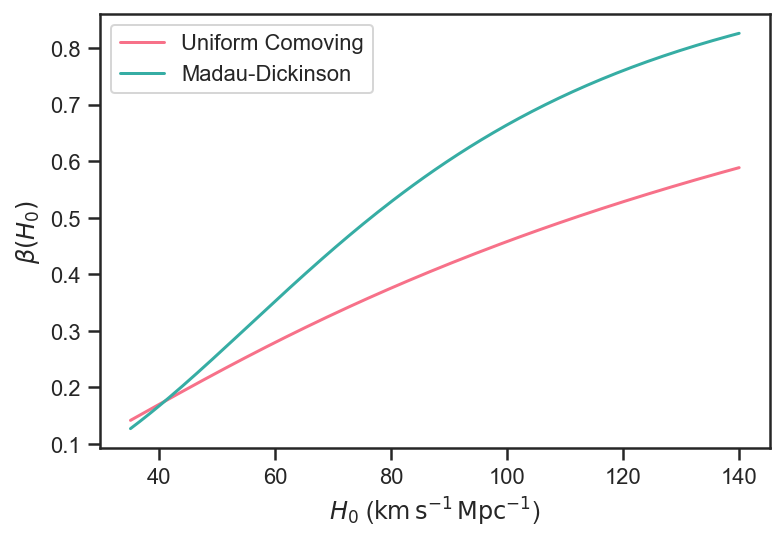

In [67]:
figure()
with sns.color_palette('husl', n_colors=2):
    plot(H0s, betas_unif, label='Uniform Comoving')
    plot(H0s, betas_MD, label='Madau-Dickinson')
    legend(loc='best')
    xlabel(r'$H_0$ ($\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$)')
    ylabel(r'$\beta\left( H_0 \right)$')

Correcting for selection, we find:

In [68]:
p_H0_unif = p_H0 / interp(H0_of_d, H0s, betas_unif)
p_H0_MD = p_H0 / interp(H0_of_d, H0s, betas_MD)

p_H0_unif /= trapz(p_H0_unif, H0_of_d)
p_H0_MD /= trapz(p_H0_MD, H0_of_d)

Planck15 H0 found at p = 0.68 in likelihood (M-D selection)


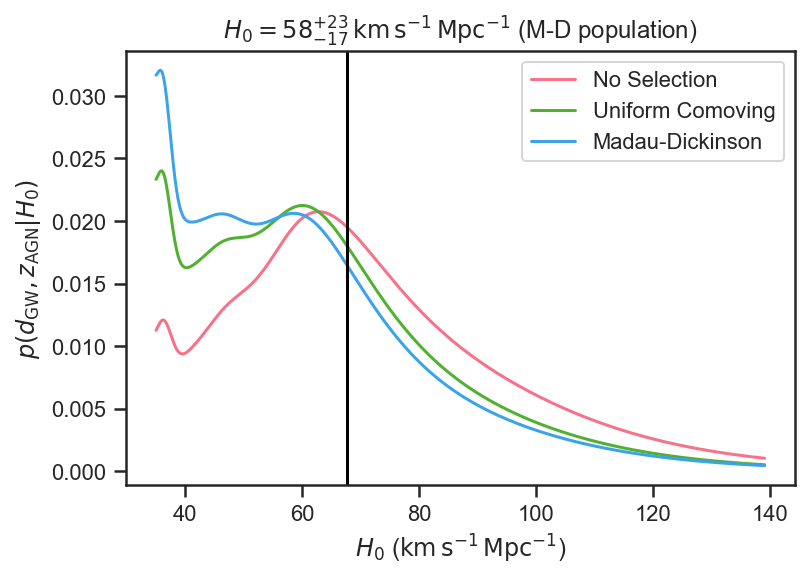

In [69]:
figure()
with sns.color_palette('husl', n_colors=3):
    plot(H0_of_d, p_H0, label='No Selection')
    plot(H0_of_d, p_H0_unif, label='Uniform Comoving')
    plot(H0_of_d, p_H0_MD, label='Madau-Dickinson')
    axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value, color='k')
    xlabel(r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
    ylabel(r'$p\left( d_\mathrm{GW}, z_\mathrm{AGN} | H_0 \right)$')

    c_H0 = cumtrapz(p_H0_MD, H0_of_d, initial=0)
    print('Planck15 H0 found at p = {:.2f} in likelihood (M-D selection)'.format(interp(Planck15.H0.to(u.km/u.s/u.Mpc).value, H0_of_d, c_H0)))
    m = interp(0.5, c_H0, H0_of_d)
    l = interp(0.16, c_H0, H0_of_d)
    h = interp(0.84, c_H0, H0_of_d)
    title(r'$H_0 = {:.0f}^{{+{:.0f}}}_{{-{:.0f}}} \, \mathrm{{km}} \, \mathrm{{s}}^{{-1}} \, \mathrm{{Mpc}}^{{-1}}$ (M-D population)'.format(m, h-m, m-l))
    legend(loc='best')

It is interesting to combine this measurement with the *other* counterpart $H_0$ measurement from GW170817 ([Abbott, et al. (2017)](http://doi.org/10.1038/nature24471)).  You can download the posterior on $H_0$ from that measurement [here](https://dcc.ligo.org/LIGO-P1700296/public).

In [72]:
BNS_H0 = pd.read_csv('https://dcc.ligo.org/public/0145/P1700296/005/Figure1.csv')
BNS_H0

,H0_samples
0,72.617575
1,62.498661
2,112.420731
3,63.506926
4,59.122734
...,...
131067,94.211067
131068,75.030941
131069,103.207495
131070,67.447858


These are posterior samples from the 170817 measurement with a $1/H_0$ prior.  [Abbott, et al. (2017)](http://doi.org/10.1038/nature24471) do not correct for selection effects.  We can estimate the $\beta$ function for 170817 using a similar approach as above; here we assume the detection horizon is $\sim 150\,\mathrm{Mpc}$.

In [83]:
zs = expm1(linspace(log(1), log(1+10), 1024))
H0s = logspace(log10(35), log10(140), 128)
dL_horiz = 0.150
betas_unif_170817 = []
for H in tqdm(H0s):
    c = cosmo.FlatLambdaCDM(H*u.km/u.s/u.Mpc, Planck15.Om0)
    pz = Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value/(1+zs)
    pz /= trapz(pz, zs)
    cz = cumtrapz(pz, zs, initial=0)
    betas_unif_170817.append(interp(cosmo.z_at_value(c.luminosity_distance, dL_horiz*u.Gpc), zs, cz))
betas_unif_170817 = array(betas_unif_170817)

100%|██████████| 128/128 [00:03<00:00, 38.94it/s]


In [88]:
zs = expm1(linspace(log(1), log(1+20), 1024))
H0s = logspace(log10(35), log10(140), 128)
dL_horiz = 0.150
betas_MD_170817 = []
for H in tqdm(H0s):
    c = cosmo.FlatLambdaCDM(H*u.km/u.s/u.Mpc, Planck15.Om0)
    pz = (1+zs)**2.7/(1 + ((1+zs)/(1+1.9))**5.6)*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value/(1+zs)
    pz /= trapz(pz, zs)
    cz = cumtrapz(pz, zs, initial=0)
    betas_MD_170817.append(interp(cosmo.z_at_value(c.luminosity_distance, dL_horiz*u.Gpc), zs, cz))
betas_MD_170817 = array(betas_MD_170817)

100%|██████████| 128/128 [00:03<00:00, 33.88it/s]


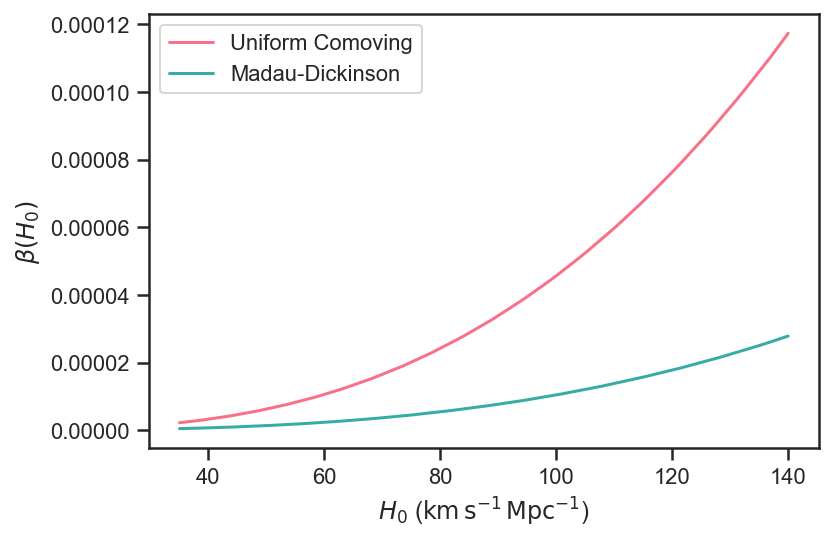

In [91]:
figure()
with sns.color_palette('husl', n_colors=2):
    plot(H0s, betas_unif_170817, label='Uniform Comoving')
    plot(H0s, betas_MD_170817, label='Madau-Dickinson')
    legend(loc='best')
    xlabel(r'$H_0$ ($\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$)')
    ylabel(r'$\beta\left( H_0 \right)$')

Estimating the posterior density from [Abbott, et al. (2017)](http://doi.org/10.1038/nature24471), correcting for selection effects, and removing the prior ($1/H_0$) gives us the likelihood for $H_0$ from the GW170817 measurements:

In [93]:
k = ss.gaussian_kde(BNS_H0['H0_samples'])
p170817_unif = k(H0_of_d)*H0_of_d / interp(H0_of_d, H0s, betas_unif_170817)
p170817_MD = k(H0_of_d)*H0_of_d / interp(H0_of_d, H0s, betas_MD_170817)

p170817_unif /= trapz(p170817_unif, H0_of_d)
p170817_MD /= trapz(p170817_MD, H0_of_d)

Now multiplying the two likelihoods gives the joint likelihood for the two measurements.

In [95]:
p_joint_unif = p_H0_unif * p170817_unif
p_joint_unif /= trapz(p_joint_unif, H0_of_d)

p_joint_MD = p_H0_MD * p170817_MD
p_joint_MD /= trapz(p_joint_MD, H0_of_d)

Here is the result (dashed lines show the likelihood function for 170817).  GW190521 is informative, particularly at the upper range of $H_0$ permitted by 170817.  The ultimate result is fairly independent of the assumed population of events because 170817 is quite informative about $H_0$ (so the beta factor does not vary much over the range of permitted $H_0$ values).

Text(0.5, 1.0, '$H_0 = 68.63^{+7.68}_{-5.58} \\, \\mathrm{km} \\, \\mathrm{s}^{-1} \\, \\mathrm{Mpc}^{-1}$')

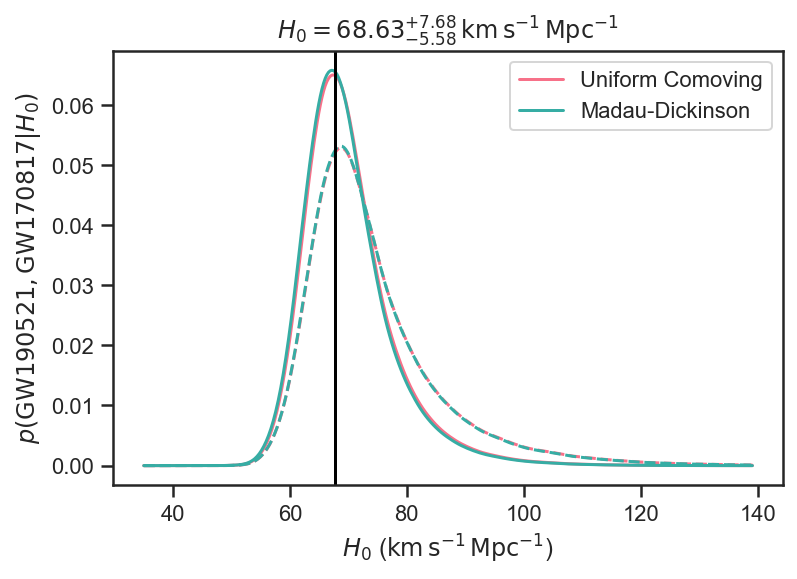

In [98]:
with sns.color_palette('husl', n_colors=2):
    l, = plot(H0_of_d, p_joint_unif, label='Uniform Comoving')
    plot(H0_of_d, p170817_unif, ls='--', color=l.get_color())
    
    l, = plot(H0_of_d, p_joint_MD, label='Madau-Dickinson')
    plot(H0_of_d, p170817_MD, ls='--', color=l.get_color())
    
    axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value, color='k')
    xlabel(r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
    ylabel(r'$p\left( \mathrm{GW190521}, \mathrm{GW170817} | H_0 \right)$')
    legend(loc='best')    

c_joint_MD = cumtrapz(p_joint_MD, H0_of_d, initial=0)
m = interp(0.5, c_joint_MD, H0_of_d)
h = interp(0.84, c_joint_MD, H0_of_d)
l = interp(0.16, c_joint_MD, H0_of_d)

title(r'$H_0 = {:.2f}^{{+{:.2f}}}_{{-{:.2f}}} \, \mathrm{{km}} \, \mathrm{{s}}^{{-1}} \, \mathrm{{Mpc}}^{{-1}}$'.format(m, h-m, m-l))

Now comparing to (assumed Gaussian!) Planck ([Planck Collaboration, et al. (2018)](http://doi.org/10.1051/0004-6361/201833910)) and SH0ES ([Riess, et al. (2016)](http://doi.org/10.3847/0004-637x/826/1/56)) measurements; we aren't at the level of deciding between the two, though SH0ES is moving out to 1-sigma....

(50.0, 100.0, -0.0069030763933714025, 0.07264666109214665)

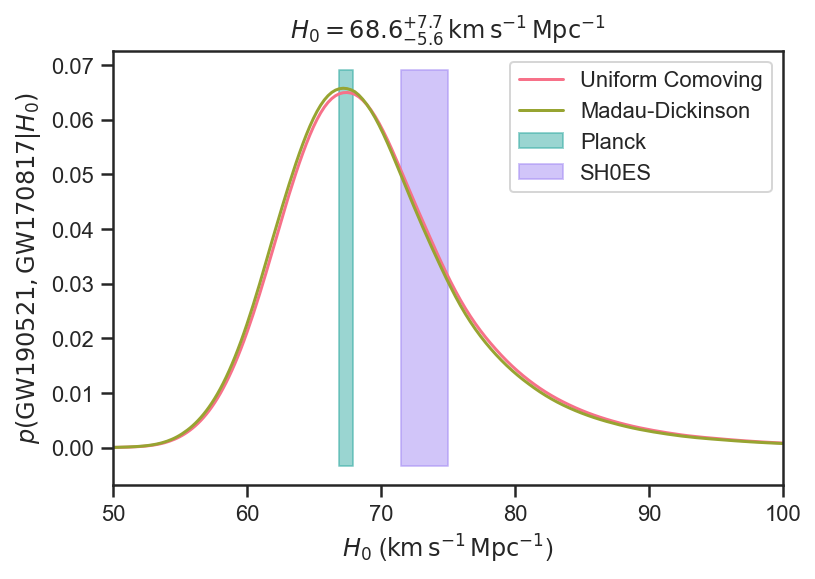

In [104]:
with sns.color_palette('husl', n_colors=4):
    l, = plot(H0_of_d, p_joint_unif, label='Uniform Comoving')
    l, = plot(H0_of_d, p_joint_MD, label='Madau-Dickinson')

    ymin, ymax = gca().get_ylim()
    
    fill_betweenx([ymin, ymax], 67.36-0.54, 67.36+0.54, label='Planck', alpha=0.5, color=sns.color_palette()[2])
    fill_betweenx([ymin, ymax], 73.24-1.74, 73.24+1.74, label='SH0ES', alpha=0.5, color=sns.color_palette()[3])
    
    xlabel(r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
    ylabel(r'$p\left( \mathrm{GW190521}, \mathrm{GW170817} | H_0 \right)$')
    legend(loc='best')    

c_joint_MD = cumtrapz(p_joint_MD, H0_of_d, initial=0)
m = interp(0.5, c_joint_MD, H0_of_d)
h = interp(0.84, c_joint_MD, H0_of_d)
l = interp(0.16, c_joint_MD, H0_of_d)

title(r'$H_0 = {:.1f}^{{+{:.1f}}}_{{-{:.1f}}} \, \mathrm{{km}} \, \mathrm{{s}}^{{-1}} \, \mathrm{{Mpc}}^{{-1}}$'.format(m, h-m, m-l))

axis(xmin=50, xmax=100)